<a href="https://colab.research.google.com/github/ryanjameskim/public/blob/master/TPT2017CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple CNN
Infrastructure copied from Tsantekidis, Passalis, Tefas, et al 2017 with few addition of Dropout layers

Data is organized as follows:
*   X and Y numpy file pairs for each trading date of various lengths
*   X data and Y data are time ordered by 200ms
*   X is a numpy array of shape (???, 16, 2) with 8 closest bid and offer sizes in one channel and the standardized price based on the last 1500 (5 min) mids and variance
*   Y is a unidimensional numpy array of shape (???,) which labels whether future average price over the next minute is higher (1), lower (-1), or unchanged (0) than the previous minute's price with a tolerance of 0.00005 (half pip)


In [17]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import keras
import random

#print(keras.__version__)

# Determine Y splits

Steps:

*   Find all the data files
*   Find total distribution of Y's


In [4]:
os.getcwd()

'/content'

In [5]:
data_files = []
for root, dirs, files in os.walk('/content'):
  for f in files:
    if '.npy' in f:
      data_files.append(f)
print(data_files)

os.chdir('/content')

['20200616_Y.npy', '20200617_Y.npy', '20200630_Y.npy', '20200723_Y.npy', '20200612_Y.npy', '20200723_X.npy', '20200612_X.npy', '20200623_X.npy', '20200610_Y.npy', '20200717_Y.npy', '20200603_Y.npy', '20200602_X.npy', '20200701_Y.npy', '20200611_X.npy', '20200622_X.npy', '20200722_Y.npy', '20200605_Y.npy', '20200618_Y.npy', '20200720_Y.npy', '20200611_Y.npy', '20200624_X.npy', '20200618_X.npy', '20200616_X.npy', '20200609_X.npy', '20200602_Y.npy', '20200608_Y.npy', '20200625_X.npy', '20200615_X.npy', '20200619_Y.npy', '20200623_Y.npy', '20200603_X.npy', '20200716_X.npy', '20200710_X.npy', '20200717_X.npy', '20200714_X.npy', '20200605_X.npy', '20200604_Y.npy', '20200626_X.npy', '20200714_Y.npy', '20200609_Y.npy', '20200619_X.npy', '20200721_X.npy', '20200622_Y.npy', '20200608_X.npy', '20200701_X.npy', '20200713_X.npy', '20200610_X.npy', '20200721_Y.npy', '20200625_Y.npy', '20200617_X.npy', '20200624_Y.npy', '20200722_X.npy', '20200713_Y.npy', '20200626_Y.npy', '20200715_Y.npy', '20200630

In [6]:
#collect Y's
y_files = [f for f in data_files if '_Y' in f]
all_Y = np.load(y_files[0]).reshape(-1,1)
for f in y_files[1:]:
  all_Y = np.vstack((all_Y, np.load(f).reshape(-1,1)))
all_Y.shape

y_length = all_Y.shape[0]

In [7]:
unique, counts = np.unique(all_Y, return_counts=True)
print(dict(zip(unique, counts)))
print(f'Third of Y values: {int(y_length / 3)}')


{-1: 754826, 0: 1031519, 1: 751865}
Third of Y values: 846070


#  Collect X's

Steps:

*   Store all lengths of X as dictionary
*   Number all X files
*   Create index of all files with replacement --> lines without replacement
*   array will look like this: [(1,500), (8, 200), ...] and so on
*   Generator looks up the first 32 index tuples and then appends chosen X and Y's to batch
*   Yield a batch

In [8]:
# Collect X files
x_files = [f for f in data_files if '_X' in f]

# Collect X file lengths into dictionary
x_file_lengths = {f : len(np.load(f)) for f in x_files}

# Print X file lengths
print(f'X File Lengths by Filename:')
x_file_lengths

X File Lengths by Filename:


{'20200602_X.npy': 28379,
 '20200603_X.npy': 16713,
 '20200604_X.npy': 31017,
 '20200605_X.npy': 17401,
 '20200608_X.npy': 26935,
 '20200609_X.npy': 79595,
 '20200610_X.npy': 24953,
 '20200611_X.npy': 16927,
 '20200612_X.npy': 26935,
 '20200615_X.npy': 51527,
 '20200616_X.npy': 60372,
 '20200617_X.npy': 72435,
 '20200618_X.npy': 53521,
 '20200619_X.npy': 104322,
 '20200622_X.npy': 218779,
 '20200623_X.npy': 25739,
 '20200624_X.npy': 131306,
 '20200625_X.npy': 253311,
 '20200626_X.npy': 26285,
 '20200630_X.npy': 59392,
 '20200701_X.npy': 148620,
 '20200710_X.npy': 76908,
 '20200713_X.npy': 112906,
 '20200714_X.npy': 112752,
 '20200715_X.npy': 88974,
 '20200716_X.npy': 134879,
 '20200717_X.npy': 89638,
 '20200720_X.npy': 52409,
 '20200721_X.npy': 103925,
 '20200722_X.npy': 105472,
 '20200723_X.npy': 100946,
 '20200724_X.npy': 84937}

In [9]:
# Ensure x and y files are sorted
x_files = sorted(x_files)
print(x_files)

y_files = sorted(y_files)
print(y_files)

if not len(x_files) == len(y_files):
  print(f'Check uploaded files!')

print(x_file_lengths)

['20200602_X.npy', '20200603_X.npy', '20200604_X.npy', '20200605_X.npy', '20200608_X.npy', '20200609_X.npy', '20200610_X.npy', '20200611_X.npy', '20200612_X.npy', '20200615_X.npy', '20200616_X.npy', '20200617_X.npy', '20200618_X.npy', '20200619_X.npy', '20200622_X.npy', '20200623_X.npy', '20200624_X.npy', '20200625_X.npy', '20200626_X.npy', '20200630_X.npy', '20200701_X.npy', '20200710_X.npy', '20200713_X.npy', '20200714_X.npy', '20200715_X.npy', '20200716_X.npy', '20200717_X.npy', '20200720_X.npy', '20200721_X.npy', '20200722_X.npy', '20200723_X.npy', '20200724_X.npy']
['20200602_Y.npy', '20200603_Y.npy', '20200604_Y.npy', '20200605_Y.npy', '20200608_Y.npy', '20200609_Y.npy', '20200610_Y.npy', '20200611_Y.npy', '20200612_Y.npy', '20200615_Y.npy', '20200616_Y.npy', '20200617_Y.npy', '20200618_Y.npy', '20200619_Y.npy', '20200622_Y.npy', '20200623_Y.npy', '20200624_Y.npy', '20200625_Y.npy', '20200626_Y.npy', '20200630_Y.npy', '20200701_Y.npy', '20200710_Y.npy', '20200713_Y.npy', '2020071

In [10]:
# Sum total lines in X files
total_X_length = sum(x_file_lengths[key] for key in x_file_lengths)

# Ensure match with Y length
if not total_X_length == y_length:
  print(f'Check X and Y lengths!')

# Total number of lines
print(f'Total number of lines in training set: {total_X_length}')

Total number of lines in training set: 2538210


# Create index lookup for X

Using example of three files of 10 length each. 3 lookback.
*  total_X_length = 30
*  index_to_file = {7: first.npy, 14: second.npy, 21: third.npy}
   *   if up to 7, goes to first.npy (0 --> first.npy(0,1,2), 7 --> first.npy(7,8,9))
   *   if goes to 8, need to subtract (7+1) row in second.npy (8 --> second.npy(0,1,2), 15 --> second.npy(7,8,9))
      *   last valid line in second.npy is 7 + (7+1) = 15
   *   if goes to 16, need to subtract (15 + 1) row in third.npy (16 --> third,npy(0,1,2), 23 --> third.npy(7,8,9))

index_list = [0, 1, 2, 3, ... , 21, 22, 23]

x_file_length[0] - lookback + 1 --> -1 + 10 - 3 + 1 = 7
*   x_file_length[1] - lookback + 1 --> 7 + 10 - 3 + 1 = 15
*   x_file_length[2] - lookback + 1 --> 15 + 10 - 3 + 1 = 23

index_list = range(total_X_length - lookback * 3 + (3))  <--- remember this is RANGE, so it's 24 items, but ends in 23




In [11]:
orderbook_look_size = 300
index_list = list(range(total_X_length-orderbook_look_size * len(x_file_lengths) + (len(x_file_lengths))))

max_index = -1
tuple_to_key = {}
low = 0
for date_key in sorted(x_file_lengths):
  max_index += x_file_lengths[date_key] - orderbook_look_size + 1
  tuple_to_key[(low, max_index)] = date_key
  low = max_index + 1

print(tuple_to_key)
print(index_list[-1])

{(0, 28079): '20200602_X.npy', (28080, 44493): '20200603_X.npy', (44494, 75211): '20200604_X.npy', (75212, 92313): '20200605_X.npy', (92314, 118949): '20200608_X.npy', (118950, 198245): '20200609_X.npy', (198246, 222899): '20200610_X.npy', (222900, 239527): '20200611_X.npy', (239528, 266163): '20200612_X.npy', (266164, 317391): '20200615_X.npy', (317392, 377464): '20200616_X.npy', (377465, 449600): '20200617_X.npy', (449601, 502822): '20200618_X.npy', (502823, 606845): '20200619_X.npy', (606846, 825325): '20200622_X.npy', (825326, 850765): '20200623_X.npy', (850766, 981772): '20200624_X.npy', (981773, 1234784): '20200625_X.npy', (1234785, 1260770): '20200626_X.npy', (1260771, 1319863): '20200630_X.npy', (1319864, 1468184): '20200701_X.npy', (1468185, 1544793): '20200710_X.npy', (1544794, 1657400): '20200713_X.npy', (1657401, 1769853): '20200714_X.npy', (1769854, 1858528): '20200715_X.npy', (1858529, 1993108): '20200716_X.npy', (1993109, 2082447): '20200717_X.npy', (2082448, 2134557): '

# Repeat process for validation set

In [12]:
val_files = []
for root, dirs, files in os.walk('/validation'):
  for f in files:
    if '.npy' in f:
      val_files.append(''.join(root + '/' + f))
print(val_files)

#collect Y's
val_y_files = [f for f in val_files if '_Y' in f]
val_all_Y = np.load(val_y_files[0]).reshape(-1,1)
for f in val_y_files[1:]:
  val_all_Y = np.vstack((val_all_Y, np.load(f).reshape(-1,1)))
val_y_length = val_all_Y.shape[0]

# Collect X files
val_x_files = [f for f in val_files if '_X' in f]

# Collect X file lengths into dictionary
val_x_file_lengths = {f : len(np.load(f)) for f in val_x_files}

# Ensure x and y files are sorted
val_x_files = sorted(x_files)
val_y_files = sorted(y_files)

# Sum total lines in X files
val_total_X_length = sum(val_x_file_lengths[key] for key in val_x_file_lengths)

# Ensure match with Y length
if not val_total_X_length == val_y_length:
  print(f'Check Validation X and Y lengths!')

# Total number of lines
print(f'Total number of lines in validation set: {val_total_X_length}')

#create validation tuple to key
val_index_list = list(range(val_total_X_length-orderbook_look_size * len(val_x_file_lengths) + (len(val_x_file_lengths))))

val_max_index = -1
val_tuple_to_key = {}
val_low = 0
for date_key in sorted(val_x_file_lengths):
  val_max_index += val_x_file_lengths[date_key] - orderbook_look_size + 1
  val_tuple_to_key[(val_low, val_max_index)] = date_key
  val_low = val_max_index + 1

print(val_tuple_to_key)
print(val_index_list[-1])


['/validation/20200727_X.npy', '/validation/20200728_X.npy', '/validation/20200728_Y.npy', '/validation/20200729_Y.npy', '/validation/20200727_Y.npy', '/validation/20200729_X.npy']
Total number of lines in validation set: 220529
{(0, 79175): '/validation/20200727_X.npy', (79176, 160156): '/validation/20200728_X.npy', (160157, 219631): '/validation/20200729_X.npy'}
219631


#   Create Data Generator

*    This randomly selects integers from a range and then looks up which trading file to open
*    Collects 300 (1 minute) pictures of data with which to train the CNN

In [13]:
class DataGenerator(keras.utils.Sequence):
#Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    'Generates data for Keras'
    def __init__(self, tuple_to_key, index_list, batch_size=32, dim=(300,16), n_channels=2,
                 n_classes=3, split=.00005, shuffle=True, verbose=False, orderbook_look_size=300):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.tuple_to_key = tuple_to_key
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.index_list = index_list
        self.orderbook_look_size = orderbook_look_size
        self.verbose=verbose
        self.split = split
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.index_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self, verbose=True):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.index_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        if verbose:
          print(f'New Shuffle! Index beginning {self.indexes[:3]}')

    def Y_one_hot(self, single_Y):
      category_Y = np.zeros((self.n_classes, single_Y.shape[0]))
      for i in range(single_Y.shape[0]):
        if single_Y[i] > self.split:
          category_Y[2, i] = 1
        elif single_Y[i] > -self.split:
          category_Y[1, i] = 1
        else:
          category_Y[0, i] = 1
        return category_Y[:,0]

    def __data_generation(self, indexes, verbose = False):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for batch_i, ID in enumerate(indexes):
            # Find index within tuple dictionary
            for tuple_pair in self.tuple_to_key:
              if ID >= tuple_pair[0] and ID < tuple_pair[1]:
                f = self.tuple_to_key[tuple_pair]
                y_file = f.split('_')[0]+'_Y.npy'

                # Print index range with file name
                if verbose:
                  print(f'{ID} uses X: {f} lines {ID-tuple_pair[0]} to {ID-tuple_pair[0]+self.orderbook_look_size} \nY: {y_file} line {ID-tuple_pair[0]+self.orderbook_look_size}')
                  
                # Store X sample
                X[batch_i,] = np.load(f)[ID-tuple_pair[0]:ID-tuple_pair[0]+self.orderbook_look_size, :]

                # Determine y sample
                pre_cat_y = np.load(y_file).reshape(-1,1)[ID-tuple_pair[0]+self.orderbook_look_size]
                y[batch_i] = self.Y_one_hot(pre_cat_y)

        return X, y

#  CNN Model

In [14]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
DefaultConv1D = partial(keras.layers.Conv1D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=16, kernel_size=(2, 40), input_shape=[300, 16, 2]),
    DefaultConv1D(filters=16, kernel_size=2),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv1D(filters=32, kernel_size=3),
    DefaultConv1D(filters=32, kernel_size=3),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

#  Training step

*    Takes about 3 hours for 1 epoch on Colabs Pro


In [15]:
# Parameters
params = {'dim': (300,16),
          'batch_size': 128,
          'n_classes': 3,
          'n_channels': 2,
          'shuffle': True}

training_generator = DataGenerator(tuple_to_key, index_list, **params)
validation_generator = DataGenerator(val_tuple_to_key, val_index_list, **params)

model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit_generator(generator=training_generator,
                              use_multiprocessing=True,
                              epochs = 2,
                              workers=6)

model.save_weights('ZZR2019simplecnnweights')

New Shuffle! Index beginning [ 729886 2409842 1895984]
New Shuffle! Index beginning [169073  35465 144431]
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
19755/19755 [==============================] - 11513s 583ms/step - loss: 1.0869 - accuracy: 0.4068
New Shuffle! Index beginning [1226096  823105 1723400]
Epoch 2/2
19755/19755 [==============================] - 11119s 563ms/step - loss: 1.0869 - accuracy: 0.4069
New Shuffle! Index beginning [131565 863230 926897]


In [16]:
model.evaluate_generator(generator=validation_generator, steps = 1000)

Instructions for updating:
Please use Model.evaluate, which supports generators.
New Shuffle! Index beginning [ 34600 146370 185982]


[1.1018470525741577, 0.36213281750679016]

In [19]:
loss = history.history['loss']

In [20]:
epochs = range(1, len(loss) + 1)

NameError: ignored

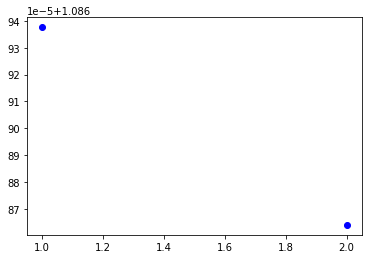

In [21]:
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()